In [2]:
import os
import subprocess
import numpy as np
from typing import Optional
from matplotlib import pyplot as plt

TODO: script for generating plumed_reweight.dat from plumed.dat

In [10]:
def get_fe_grid(data, reweight=False):
    if reweight:
        delta_idx = 1
    else:
        delta_idx = 0
    feature1_traj = data[:, 0+delta_idx]
    feature2_traj = data[:, 1+delta_idx]
    fe = data[:, 2+delta_idx] - np.min(data[:, 2+delta_idx])
    return feature1_traj, feature2_traj, fe

def remove_nans(data: np.array, axis: int = 1) -> np.array:
    num_nans = np.count_nonzero(np.isnan(data))
    if num_nans > 0:
        axis_str = "rows" if axis == 1 else "columns"
        print(f"{num_nans} NaNs detected, removing {axis_str} with NaNs.")
        data = data[~np.isnan(data).any(axis=1), :]

    return data

def init_plot(
    title: Optional[str],
    xlabel: Optional[str],
    ylabel: Optional[str],
    figsize=(6, 4),
    xscale="linear",
    yscale="linear",
    grid_on: bool = False,
    ax=None,
):
    if not ax:
        # If no axis provided, generate one (default)
        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(title)
    else:
        fig = None
    ax.set(xscale=xscale, yscale=yscale, xlabel=xlabel, ylabel=ylabel)
    ax.grid(grid_on)

    return fig, ax

In [11]:
def contour_fes(feature1_traj, feature2_traj, bias_potential_traj, xlabel, ylabel, xcorrection, ycorrection, reweight=False):
    feature_traj = np.vstack((feature1_traj, feature2_traj)).T
    xyz = remove_nans(np.hstack([feature_traj, np.array([bias_potential_traj]).T]))
    x = xyz[:, 0]
    y = xyz[:, 1]
    free_energy = xyz[:, 2]
    beta = 0.2 #todo: change
    num_levels = int(
        np.floor((np.max(free_energy) - np.min(free_energy)) * beta)
    )
    levels = [k * 1 / beta for k in range(num_levels + 2)]  # todo: why +2?
    fig, ax = init_plot(xlabel=xlabel, ylabel=ylabel, title='FES')
    if reweight:
        im = ax.contourf(x, y, free_energy, levels=levels, cmap="RdBu_r")
    else:
        im = ax.tricontourf(x, y, free_energy, levels=levels, cmap="RdBu_r")
        ax.tricontour(x, y, free_energy, levels=levels, linewidths=0.5, colors="k")
    ax.set_xlim([-np.pi+xcorrection,np.pi+xcorrection])
    ax.set_ylim([-np.pi+ycorrection,np.pi+ycorrection])

In [14]:
def process_free_energy_surface(directory, xlabel, ylabel, xcorrection, ycorrection, plot=True, reweight=False):
    HILLS_file = os.path.join(directory, 'HILLS')
    os.chdir(directory)
    # TODO: update kT
    if reweight:
        subprocess.call(f"plumed driver --mf_dcd {directory}/trajectory.dcd --plumed {directory}/plumed_reweight.dat --kt {2.494339}", shell=True)
        dat_file = os.path.join(directory, 'COLVAR_REWEIGHT')
    else:
        subprocess.call(f"plumed sum_hills --hills {HILLS_file}", shell=True)
        dat_file = os.path.join(directory, 'fes.dat')
    data = np.genfromtxt(f"{dat_file}", autostrip=True)
    feature1_traj, feature2_traj, fe = get_fe_grid(data, reweight=reweight)
    if plot:
        contour_fes(feature1_traj, feature2_traj, fe, xlabel, ylabel, xcorrection, ycorrection)

    return feature1_traj, feature2_traj, fe

In [5]:
def plot_average_fes(directory, xlabel, ylabel, xcorrection , ycorrection):
    for subdirectory_tuple in os.walk(directory):
        subdirs = subdirectory_tuple[1]
        feat1s = []
        feat2s = []
        fes = []
        for subdir in subdirs:
            subdir = os.path.join(directory, subdir)
            feat1, feat2, fe = process_free_energy_surface(subdir, plot=False)
            feat1s.append(feat1)
            feat2s.append(feat2)
            fes.append(fe)

        feat1 = np.concatenate(feat1s)
        feat2 = np.concatenate(feat2s)
        fes = np.concatenate(fes)
        contour_fes(feat1, feat2, fes, xlabel, ylabel, xcorrection, ycorrection)
        break

## Alanine Dipeptide

phicorrection = --1.4971760511398315
psicorrection = -1.503533124923706

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

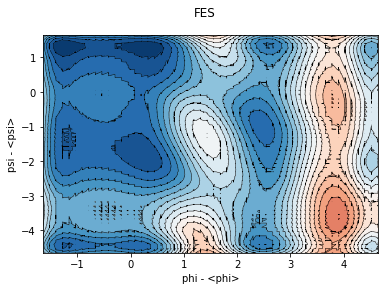

In [97]:
plot_average_fes('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/phi_psi_NVT')

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

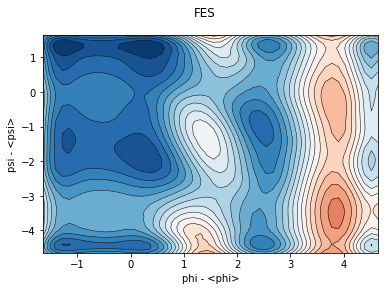

In [83]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/phi_psi_NVT/PHI_0_ALA_2_PSI_0_ALA_2_structure0_repeat_0')

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

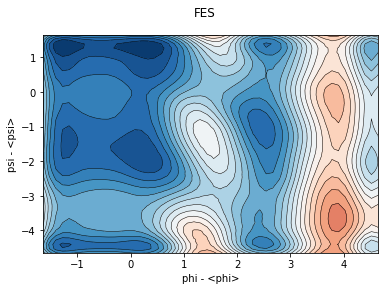

In [84]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/phi_psi_NVT/PHI_0_ALA_2_PSI_0_ALA_2_structure1_repeat_0')

In [ ]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/phi_psi_NVT/PHI_0_ALA_2_PSI_0_ALA_2_structure2_repeat_0')

### PCA Enhanced Sampling


DRIVER: Found molfile format trajectory dcd with name /home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_4_feature_dimensions_None/trajectory.dcd
dcdplugin) detected standard 32-bit DCD file of native endianness
dcdplugin) CHARMM format DCD file (also NAMD 2.1 and later)
PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: driver
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 616
PLUMED: File suffix: 
PLUMED: FILE: /home

(array([-1.612764, -1.40377 , -2.339744, ...,  0.976634,  0.882177,
         1.305113]),
 array([-0.216096,  2.749792, -0.492221, ...,  0.618421,  0.750624,
         0.08403 ]),
 array([87.063094, 89.542712, 78.167063, ..., 73.841693, 58.958538,
        28.49253 ]))

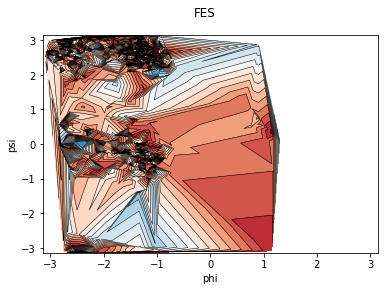

In [15]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/alanine_dipeptide/enhanced_sampling/PCA:0_PCA:1_structure0_repeat_0_total_features_4_feature_dimensions_None', xlabel='phi', ylabel='psi', xcorrection=0, ycorrection=0, reweight=True)

## Chignolin

In [1]:
from Experiment import Experiment


ModuleNotFoundError: No module named 'Experiment'

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41192   , -5.28856732, -5.16521465, ...,  3.09941465,
         3.22276732,  3.34612   ]),
 array([-3.97203, -3.97203, -3.97203, ...,  4.78602,  4.78602,  4.78602]),
 array([148.82706677, 148.82706677, 148.82706677, ..., 148.82706677,
        148.82706677, 148.82706677]))

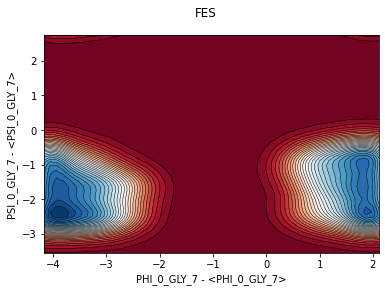

In [6]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure14_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41193   , -5.28857704, -5.16522409, ...,  3.09942408,
         3.22277704,  3.34613   ]),
 array([-3.97203, -3.97203, -3.97203, ...,  4.78602,  4.78602,  4.78602]),
 array([144.81299653, 144.81299653, 144.81299653, ..., 144.81299653,
        144.81299653, 144.81299653]))

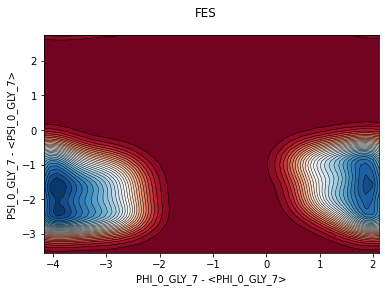

In [7]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure17_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41193   , -5.28857704, -5.16522409, ...,  3.09942408,
         3.22277704,  3.34613   ]),
 array([-3.97201, -3.97201, -3.97201, ...,  4.786  ,  4.786  ,  4.786  ]),
 array([146.52718714, 146.52718714, 146.52718714, ..., 146.52718714,
        146.52718714, 146.52718714]))

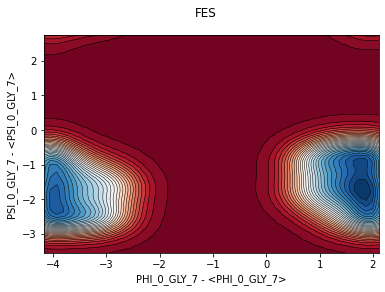

In [8]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure18_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)


## Some incomplete runs

49% complete

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41192   , -5.28856761, -5.16521521, ...,  3.09939521,
         3.22274761,  3.3461    ]),
 array([-3.97204, -3.97204, -3.97204, ...,  4.78601,  4.78601,  4.78601]),
 array([125.01980706, 125.01980706, 125.01980706, ..., 125.01980706,
        125.01980706, 125.01980706]))

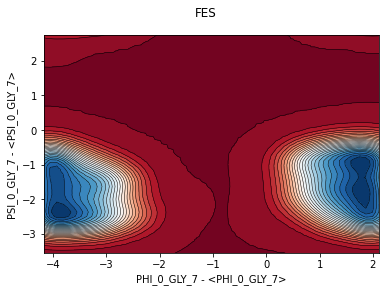

In [9]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure19_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)


33% complete

PLUMED: PLUMED is starting
PLUMED: Version: 2.8.1 (git: Unknown) compiled on Oct 21 2022 at 17:04:43
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/dominic/miniconda3/envs/diffusion/lib/plumed
PLUMED: For installed feature, see /home/dominic/miniconda3/envs/diffusion/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

(array([-5.41191   , -5.28855747, -5.16520493, ...,  3.09941493,
         3.22276746,  3.34612   ]),
 array([-3.97199, -3.97199, -3.97199, ...,  4.78578,  4.78578,  4.78578]),
 array([124.95908089, 124.95908089, 124.95908089, ..., 124.95908089,
        124.95908089, 124.95908089]))

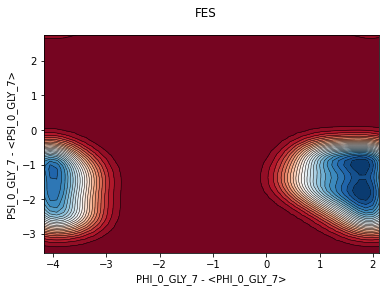

In [11]:
process_free_energy_surface('/home/dominic/PycharmProjects/CV_learning/exp/outputs/chignolin/enhanced_sampling/PHI_0_GLY_7_PSI_0_GLY_7_structure1_repeat_0', xlabel='PHI_0_GLY_7 - <PHI_0_GLY_7>', ylabel='PSI_0_GLY_7 - <PSI_0_GLY_7>', xcorrection=-1.0328998565673828, ycorrection=-0.4069909453392029)
